# Semantic Segmentation of Aerial Imagery<br>
Use transfer learning to generate features that can be used in a traditional machine learning algorithm to predict the semantic segments of aerial imagery

**Sources**:<br> 
Pretrained VGG16 features for semantic segmentation using Random Forest -> https://www.youtube.com/watch?v=vgdFovAZUzM&ab_channel=DigitalSreeni <br>
VGG16+RandomForest Transfer Learning -> https://www.kaggle.com/code/tomaszsupernak/vgg16-randomforest-transfer-learning-94-recall/notebook <br>
Channel ordering -> https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/<br>  

In [1]:
import numpy as np
import os
import json
from PIL import ImageColor
import cv2
import matplotlib.pyplot as plt
import glob
import random
from keras.models import Sequential, Model
from keras.layers import Conv2D
from keras.applications import VGG16
from sklearn.ensemble import RandomForestClassifier
import joblib
from skimage.metrics import mean_squared_error

In [2]:
# Copied from the Kaggle Content section -> do not use the provied json file 
hex_classes = { 'Building': '#3C1098',
                'Land': '#8429F6',
                'Road': '#6EC1E4',
                'Vegetation': '#FEDD3A',
                'Water': '#E2A929',
                'Unlabeled': '#9B9B9B'}

Convert the Hex colors to RGB

In [3]:
class_color_RGB = {classs:ImageColor.getcolor(hex_classes[classs], "RGB") for classs in hex_classes}
class_color_RGB

{'Building': (60, 16, 152),
 'Land': (132, 41, 246),
 'Road': (110, 193, 228),
 'Vegetation': (254, 221, 58),
 'Water': (226, 169, 41),
 'Unlabeled': (155, 155, 155)}

Load the images from file

In [4]:
# # Set a uniform dimension for all images & masks 
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

In [5]:
images_path = glob.glob('./Semantic segmentation dataset/**/images/*')

In [6]:
# Read all images from file, set image dimensions and convert to an array
images = []
for image in images_path:
    im = cv2.imread(image, 1)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im, (IMAGE_HEIGHT,IMAGE_WIDTH))
    images.append(im)
    
images_array = np.array(images)

In [7]:
masks_path = glob.glob('./Semantic segmentation dataset/**/masks/*')

In [8]:
# Read all masks from file, set image dimensions and convert to an array
masks = []
for mask in masks_path:
    ma = cv2.imread(mask, 1)
    ma = cv2.cvtColor(ma, cv2.COLOR_BGR2RGB)
    ma = cv2.resize(ma, (IMAGE_HEIGHT,IMAGE_WIDTH))
    masks.append(ma)
    
masks_array = np.array(masks)

Plot an image and mask

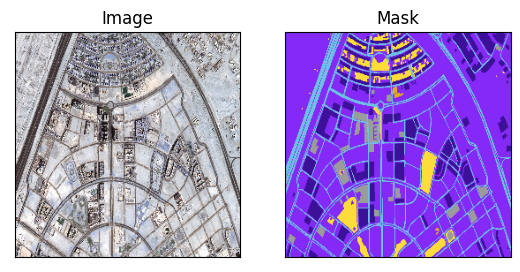

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2)
rand_index = np.random.randint(low=0, high=images_array.shape[0])
ax1.imshow(images_array[rand_index])
ax1.set_title("Image")
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
ax2.imshow(masks_array[rand_index])
ax2.set_title("Mask")
ax2.axes.xaxis.set_visible(False)
ax2.axes.yaxis.set_visible(False)
plt.show()

Split the training and test

In [10]:
x_train, x_test = images_array[:-9], images_array[-9:]
y_train, y_test = masks_array[:-9], masks_array[-9:]

In [11]:
def rgb2scalar(arr_3d:np.ndarray, rgb_vals:dict) -> np.ndarray:
    ''' Takes a collection of 3D arrays of RGB values and replaces 
        each 3D array with an int corresponding to a color and 
        returns a collection of 2D arrays '''
    arr_2d = []
    for arr in arr_3d:
        conlist = [
            arr == rgb_vals['Building'], 
            arr == rgb_vals['Land'],
            arr == rgb_vals['Road'],
            arr == rgb_vals['Vegetation'],
            arr == rgb_vals['Water'], 
            arr == rgb_vals['Unlabeled']]
        choise_list =[0,1,2,3,4,5]
        zm = np.select(condlist=conlist, choicelist=choise_list, default=5)
        arr_2d.append(zm[:,:,0])
    return np.array(arr_2d)

In [12]:
def scalar2rgb(arr2d:np.ndarray, rgb_vals:dict) -> np.ndarray:
    ''' Takes a collection of 2D arrays of scalar values and replaces
        each 2D array with a corresponding 3D RGB values and returns a 
        collectio of 3D RGB arrays '''
    
    arr_3d = []
    arr_expanded = np.repeat(arr2d[..., None], 3, axis=3) 
    for arr in arr_expanded:
        conlist = [
            arr == np.array([0,0,0]), arr == np.array([1,1,1]), arr == np.array([2,2,2]),
            arr == np.array([3,3,3]), arr == np.array([4,4,4]), arr == np.array([5,5,5])]
        choice_list = [
            rgb_vals['Building'], rgb_vals['Land'],
            rgb_vals['Road'], rgb_vals['Vegetation'],
            rgb_vals['Water'], rgb_vals['Unlabeled']]
        zm = np.select(conlist, choice_list, rgb_vals['Unlabeled'])
        arr_3d.append(zm)
    return np.array(arr_3d)
    

In [13]:
# Convert the y_train values from RGB to scalar
y_train_scalar = rgb2scalar(arr_3d=y_train, rgb_vals=class_color_RGB)

In [14]:
# recon_arr = scalar2rgb(arr2d=y_train_scalar, rgb_vals=class_color_RGB)

In [15]:
# Reshape the y_train and rename it Y
Y = y_train_scalar.reshape(-1)
Y.shape

(4128768,)

In [16]:
# Normalize the x_train data
x_train_scaled = x_train/255.
joblib.dump(x_train_scaled, "x_train_scaled.joblib")

['x_train_scaled.joblib']

In [17]:
# load the extracted features
from vgg import vgg_feature_extractor

2/2 [==============================] - 24s 11s/step


In [18]:
# Re-name the extracted features to X
X = vgg_feature_extractor
X.shape

(63, 256, 256, 64)

In [19]:
# Reshape the X for Random Forest
X = vgg_feature_extractor.reshape(-1, vgg_feature_extractor.shape[3])
X.shape

(4128768, 64)

Ramdom Forest Classifier

In [20]:
# Train the Random Forest classifier on features extracted using VGG (X) and scaler labels (Y)
rf_model = RandomForestClassifier(n_estimators=20, random_state=42, max_depth=20)
rf_model.fit(X,Y)

RandomForestClassifier(max_depth=20, n_estimators=20, random_state=42)

In [21]:
joblib.dump(rf_model, "random_forest_model.joblib")

['random_forest_model.joblib']

In [22]:
from vgg import small_vgg

In [31]:
# Normalise the x_test values
x_test_scaled = x_test/255.

In [32]:
# Generate features for the test images
test_features_x = small_vgg.predict(x_test_scaled)

1/1 [==============================] - 1s 625ms/step


In [33]:
test_features_x.shape

(9, 256, 256, 64)

In [34]:
# Reshape the test_features for Random Forest classifer
test_features_x_reshaped =  test_features_x.reshape(-1, test_features_x.shape[3])
test_features_x_reshaped.shape

(589824, 64)

In [35]:
# load the Random Forest classifier from memory
loaded_rf_model = joblib.load("random_forest_model.joblib")

In [36]:
# Use the Random Forest model to predict the scalar mask values
test_predict = loaded_rf_model.predict(test_features_x_reshaped)

In [37]:
# Reshape the predicted values back to original shape
test_pred_reshaped = test_predict.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))
test_pred_reshaped.shape

(9, 256, 256)

In [38]:
# Convert the scalar values back to RGB
test_pred_rgb = scalar2rgb(arr2d=test_pred_reshaped, rgb_vals=class_color_RGB)

Visualize the predictions vs the actuals 

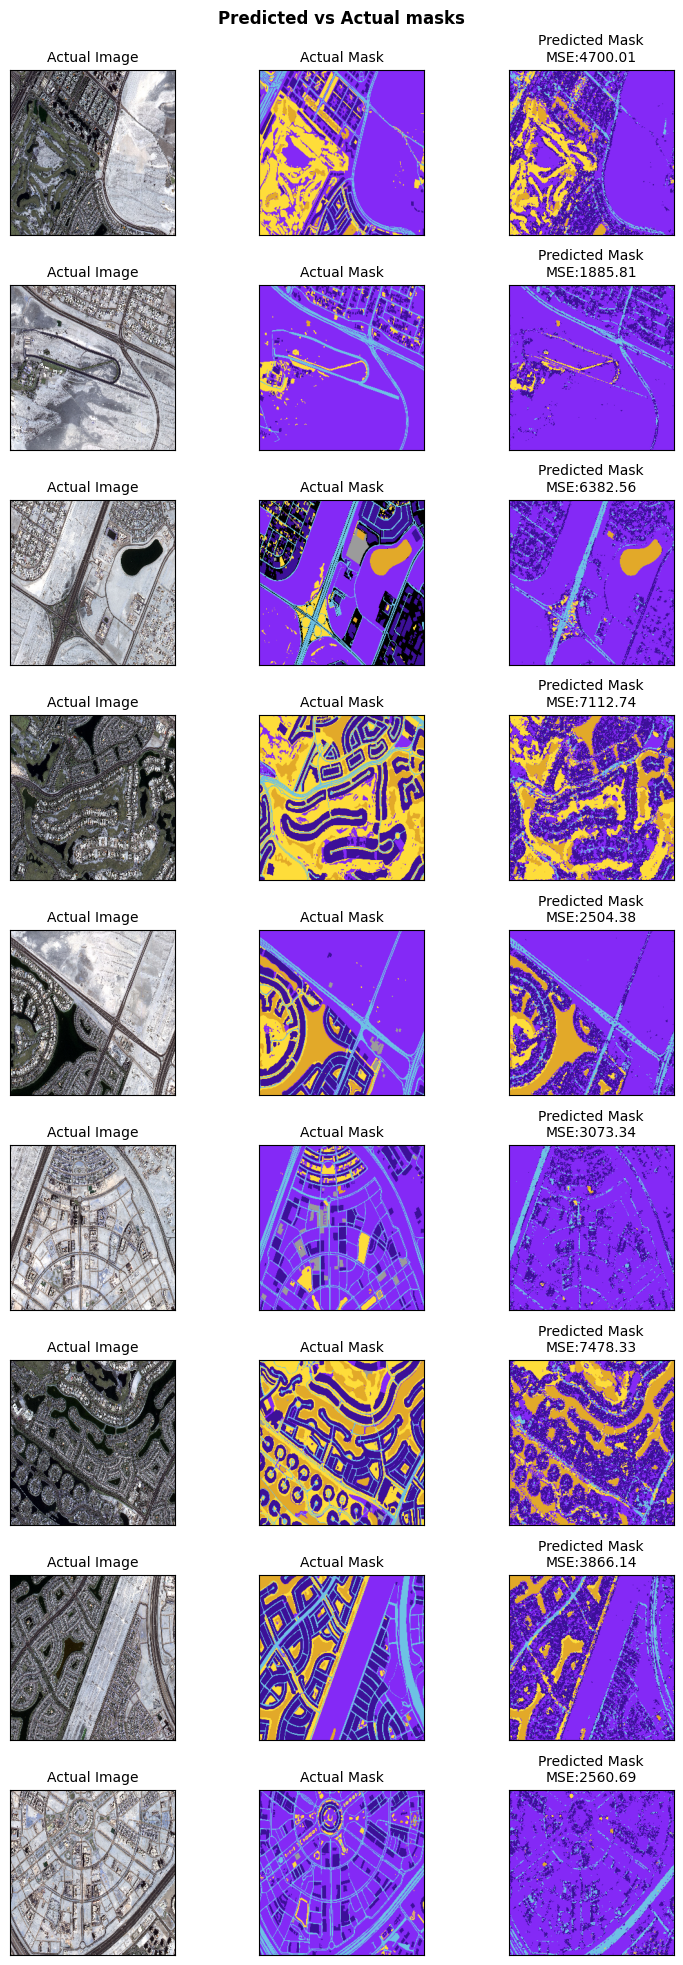

In [39]:
fig, axs = plt.subplots(x_test.shape[0], 3, figsize=(8, 20))
fig.suptitle("Predicted vs Actual masks", weight='heavy')

for row, (xt, yt, tpr) in enumerate(zip(x_test, y_test, test_pred_rgb)):
    mse = mean_squared_error(yt, tpr)

    axs[row,0].imshow(xt)
    axs[row,0].set_title('Actual Image', fontsize=10)
    axs[row,0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    axs[row,1].imshow(yt)
    axs[row,1].set_title("Actual Mask", fontsize=10)
    axs[row,1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

    axs[row,2].imshow(tpr)
    axs[row,2].set_title(f"Predicted Mask\nMSE:{mse:.2f}", fontsize=10)
    axs[row,2].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

fig.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()